In [1]:
import collections
import pandas as pd
import wandb

api = wandb.Api(overrides={"project":"poyo", "entity":"neuro-galaxy"})

# Select all the data that has the run name either willett_single_session_continue or willett_single_sesssion_scratch
# Define the run names to search for
target_run_names = ["willett_single_session_continue", "willett_single_session_scratch"]

# Retrieve and filter runs
runs = api.runs()
filtered_runs = [run for run in runs if run.name in target_run_names]

counts = collections.defaultdict(int)
scores = []

# Display the filtered runs
for run in filtered_runs:
    #print(f"Run {run.name} (id: {run.id})")
    # Find the hyperparameter configuration for the dataset
    # It should be under the hyperparameter train_datasets.0.selection.sortset=willett_shenoy_t5/t5.2020.01.13
    # The hyperparameter is a string, so we need to split it
    sortset = run.config['train_datasets'][0]['selection']['sortset'].split('/')[-1]
    metric = [x for x in run.summary.keys() if x.startswith("val/")][0]

    scores.append({
        "variant": run.name,
        "dataset": sortset,
        "score": run.summary[metric],
        "nth": counts[(run.name, sortset)]
    })

    counts[(run.name, sortset)] += 1

target_run_names = ["willett_multi_session_continue", "willett_multi_session_scratch"]

# Retrieve and filter runs
runs = api.runs()
filtered_runs = [run for run in runs if run.name in target_run_names]

# Display the filtered runs
for run in filtered_runs:
    #print(f"Run {run.name} (id: {run.id})")
    # Find the hyperparameter configuration for the dataset
    # It should be under the hyperparameter train_datasets.0.selection.sortset=willett_shenoy_t5/t5.2020.01.13
    # The hyperparameter is a string, so we need to split it
    metrics = [x for x in run.summary.keys() if x.startswith("val/")]

    for metric in metrics:
        sortset = metric.split('/')[-1].split('_')[0]
        if counts[(run.name, sortset)] > 0:
            continue
        
        scores.append({
            "variant": run.name,
            "dataset": sortset,
            "score": run.summary[metric],
            "nth": counts[(run.name, sortset)]
        })

        counts[(run.name, sortset)] += 1

In [2]:
df = pd.DataFrame(scores)
df = df[df.nth < 1]
df = df[df.dataset != 't5.2019.06.03']

In [3]:
df.pivot(index=("variant", "dataset"), columns="nth", values="score")#.loc["willett_single_session_scratch"].mean()

nth                                                   0
variant                         dataset                
willett_multi_session_continue  t5.2019.05.08  0.947917
                                t5.2019.11.25  1.000000
                                t5.2019.12.09  0.967742
                                t5.2019.12.11  0.935484
                                t5.2019.12.18  1.000000
                                t5.2019.12.20  0.967742
                                t5.2020.01.06  0.870968
                                t5.2020.01.08  0.935484
                                t5.2020.01.13  0.967742
                                t5.2020.01.15  0.935484
willett_multi_session_scratch   t5.2019.05.08  0.937500
                                t5.2019.11.25  0.935484
                                t5.2019.12.09  0.935484
                                t5.2019.12.11  0.935484
                                t5.2019.12.18  1.000000
                                t5.2019.12.20  0.967742
                                t5.2020.01.06  0.935484
                                t5.2020.01.08  0.870968
                                t5.2020.01.13  0.870968
                                t5.2020.01.15  0.870968
willett_single_session_continue t5.2019.05.08  0.906250
                                t5.2019.11.25  0.935484
                                t5.2019.12.09  0.935484
                                t5.2019.12.11  0.935484
                                t5.2019.12.18  0.967742
                                t5.2019.12.20  0.935484
                                t5.2020.01.06  0.838710
                                t5.2020.01.08  0.741935
                                t5.2020.01.13  0.774194
                                t5.2020.01.15  0.870968
willett_single_session_scratch  t5.2019.05.08  0.875000
                                t5.2019.11.25  0.838710
                                t5.2019.12.09  0.870968
                                t5.2019.12.11  0.903226
                                t5.2019.12.18  0.903226
                                t5.2019.12.20  0.870968
                                t5.2020.01.06  0.806452
                                t5.2020.01.08  0.774194
                                t5.2020.01.13  0.741935
                                t5.2020.01.15  0.741935

In [4]:
df_baselines = pd.read_csv("../data/scripts/willett_shenoy/willett_shenoy_baseline_tuned.csv")
df_baselines[['name', 'test_acc', 'test_acc_tw']]

df_b = df_baselines[df_baselines.name != "t5.2019.06.03"][['name', 'test_acc', 'test_acc_tw']]
df_b['variant'] = "knn-time-warping"
df_b.rename({'test_acc_tw': 'score', 'name': 'dataset'}, inplace=True, axis=1)

In [5]:
import numpy as np

the_map = {'knn-time-warping': 'baseline', 
           'willett_single_session_scratch': 'poyo0\nscratch',
           'willett_single_session_continue': 'poyo0\ntransfer',
           'willett_multi_session_scratch': 'poyo1\nmulti-sess\nscratch',
           'willett_multi_session_continue': 'poyo1\nmulti-sess\ntransfer',
           'willett_character_session_causal_scratch': 'poyo2\nmulti-sess causal\nscratch',
           'willett_character_session_causal_continue': 'poyo2\nmulti-sess causal\ntransfer'}

df_all = pd.concat([df, df_b], axis=0)
df_all['readable_variant'] = df_all['variant'].map(the_map)
df_all['error'] = 1 - df_all['score']
df_all['error_jittered'] = 100 * (1 - (df_all['score'] + np.random.normal(0, 0.005, size=len(df_all))))
df_all = df_all.sort_values('readable_variant')

df_results = pd.pivot_table(df_all, index="dataset", columns="readable_variant", values="error")
df_results.agg(['mean', 'sem'], axis=0).round(3)

readable_variant,baseline,poyo0\nscratch,poyo0\ntransfer,poyo1\nmulti-sess\nscratch,poyo1\nmulti-sess\ntransfer
mean,0.178,0.167,0.116,0.074,0.047
sem,0.024,0.020,0.024,0.014,0.012


In [6]:
df_results

readable_variant,baseline,poyo0\nscratch,poyo0\ntransfer,poyo1\nmulti-sess\nscratch,poyo1\nmulti-sess\ntransfer
dataset,,,,,
t5.2019.05.08,0.104167,0.125000,0.093750,0.062500,0.052083
t5.2019.11.25,0.064516,0.161290,0.064516,0.064516,0.000000
t5.2019.12.09,0.161290,0.129032,0.064516,0.064516,0.032258
t5.2019.12.11,0.129032,0.096774,0.064516,0.064516,0.064516
t5.2019.12.18,0.193548,0.096774,0.032258,0.000000,0.000000
t5.2019.12.20,0.322581,0.129032,0.064516,0.032258,0.032258
t5.2020.01.06,0.161290,0.193548,0.161290,0.064516,0.129032
t5.2020.01.08,0.161290,0.225806,0.258065,0.129032,0.064516
t5.2020.01.13,0.225806,0.258065,0.225806,0.129032,0.032258


Text(0, 0.5, 'validated classification error (%)')

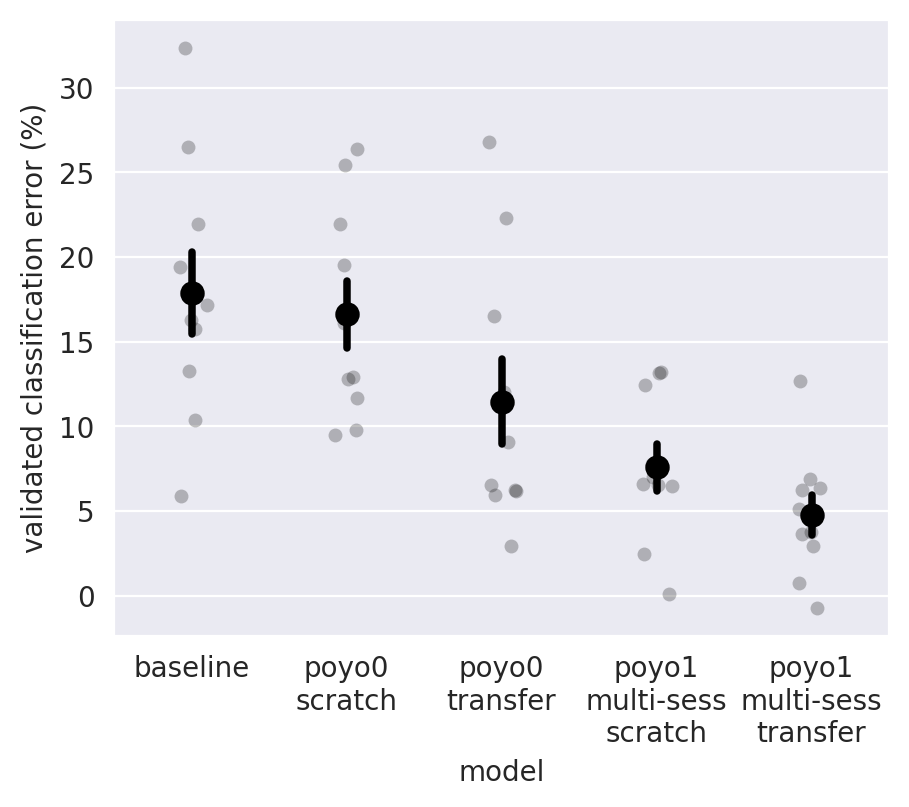

In [7]:
# plot a violin plot with these three columns in seaborn
# Use retina mode
%config InlineBackend.figure_format = 'retina'
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

plt.figure(figsize=(5, 4))

ax = sns.stripplot(x="readable_variant", y="error_jittered", data=df_all, legend=False, color="black", alpha=0.25)
sns.pointplot(x="readable_variant", y="error_jittered", data=df_all, legend=False, errorbar="se", ax=ax, color="black", linestyle="none")
plt.xlabel("model")
plt.ylabel("validated classification error (%)")
#for i in range(10):
#    plt.text(4.15, df_all.iloc[i+40].error_jittered, df_all.iloc[i]['dataset'])

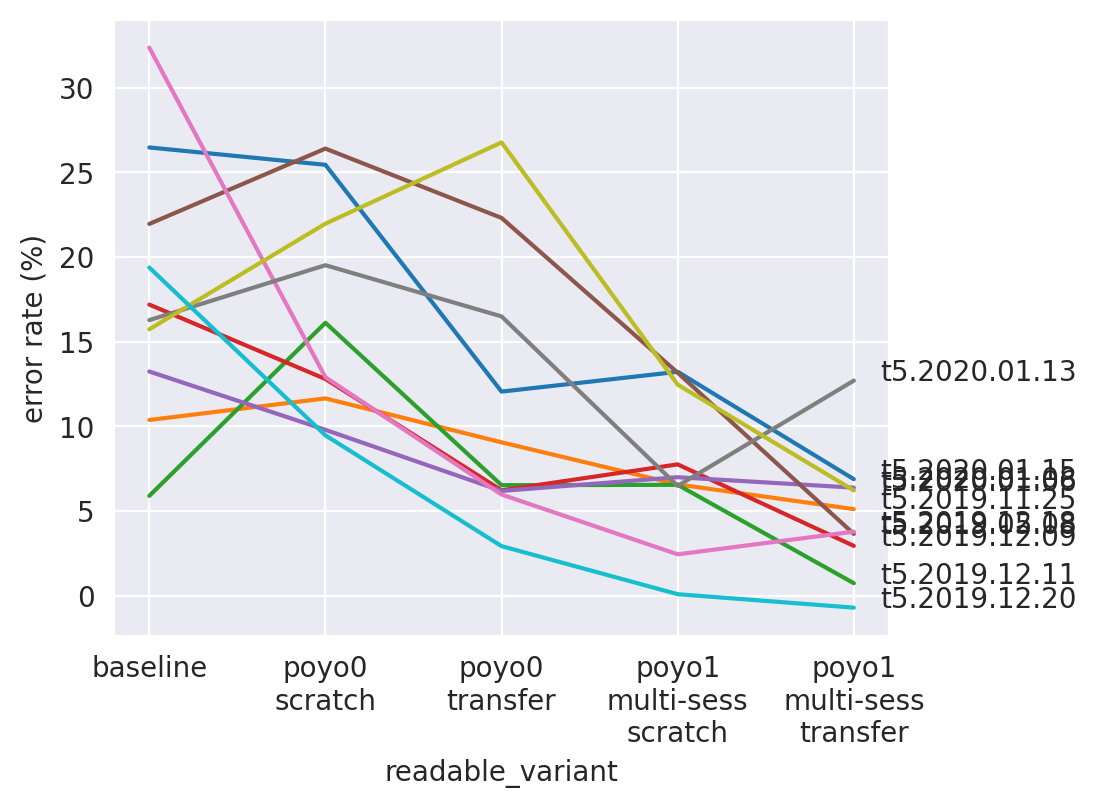

In [8]:
# plot a violin plot with these three columns in seaborn
# Use retina mode
%config InlineBackend.figure_format = 'retina'
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

plt.figure(figsize=(5, 4))

sns.lineplot(x="readable_variant", y="error_jittered", hue="dataset", data=df_all, legend=False)
plt.ylabel("error rate (%)")
for i in range(10):
    plt.text(4.15, df_all.iloc[i+40].error_jittered, df_all.iloc[i]['dataset'])